# CSE 676B
### Deep Learning
by `Prof. Alina Vereshchaka`
<br>

## <b>FINAL PROJECT</b>
<br>

<i>TEAM</i>🔻<br>
SOUBHIK SINHA (<b>soubhiks</b>)<br>
AISHWARYA MUTTINENI (<b>amuttine</b>)<br>
EKLAVYA (<b>eklavya</b>)
<br>
<br>

PROJECT TOPIC : <b><i>`BRAIN TUMOUR CLASSIFICATION USING DEEP LEARNING TECHNIQUES BASED ON MRI IMAGES`</i></b>

CHECKPOINT : <b><mark>April 4, 2024</mark></b><br>
FINAL SUBMISSION : <b><mark>May 2, 2024</mark></b>
<br><br>

COMPONENT : <b>`ResNet`</b>

In [ ]:
# Mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Let us import the necessary libraries required
# We will later on import more of them - as per requirement

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
'''
In the notebook for VGG13 implementation, we were already done with the
following :
- Data Extraction
- Data Reading
- Data Exploration
- Data Preprocessing
- Showing Main Statistics
- Splitting data into Train-Valid-Test sets
'''

# From here on we will only concentrate on the implementation of ResNet
'''
ResNet 18 Architecture : https://arxiv.org/pdf/1512.03385.pdf
'''

'\nResNet 18 Architecture : https://arxiv.org/pdf/1512.03385.pdf\n'

### <b>STEP 1 : CREATION OF DATALOADERS</b>

In [ ]:
# Loading necessary libraries (both for model implementation
# and dataloader creation)

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
# Setting device to GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
# Creating data loaders

import torch
from torchvision import transforms, datasets

# Defining a lower resolution
# new_resolution = 224

# Defining transformations with lower resolution
transform = transforms.Compose([
    # transforms.Resize((new_resolution, new_resolution)),  # Resizing images to new_resolution x new_resolution
    transforms.ToTensor(),          # Converting images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizing images
])

# Defining paths to the data
train_data_path = '/content/drive/MyDrive/Datasets/Brain_tumour_Kaggle/Training'
val_data_path = '/content/drive/MyDrive/Datasets/Brain_tumour_Kaggle/Validation'
test_data_path = '/content/drive/MyDrive/Datasets/Brain_tumour_Kaggle/Testing'

# Creating datasets with lower resolution
train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
valid_dataset = datasets.ImageFolder(root=val_data_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)

# Defining batch size
batch_size = 32

# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Lets have a look into the shape of the dataloaders

# Getting shape of train loader
for batch in train_loader:
    images, labels = batch
    print("Train Loader Shape:", images.shape)
    break  # Printing only the shape of the first batch

# Getting shape of validation loader
for batch in valid_loader:
    images, labels = batch
    print("Validation Loader Shape:", images.shape)
    break  # Printing only the shape of the first batch

# Getting shape of test loader
for batch in test_loader:
    images, labels = batch
    print("Test Loader Shape:", images.shape)
    break  # Printing only the shape of the first batch

Train Loader Shape: torch.Size([32, 3, 224, 224])
Validation Loader Shape: torch.Size([32, 3, 224, 224])
Test Loader Shape: torch.Size([32, 3, 224, 224])


<br>

### <b>STEP 2 : MODEL CREATION</b>

In [ ]:
# Lets create the ResNet-18 Architecture

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1, dropout_prob=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(dropout_prob)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        out = self.dropout(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=4, dropout_prob=0.0):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1, dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)  # Avg pooling with fixed size
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, dropout_prob):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout_prob))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.pool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# Instantiating the model
ResNet_model_base = ResNet18(num_classes=4).to(device)

In [ ]:
# Printing model summary
print(ResNet_model_base)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv

<br>

### <b>STEP 3 : MODEL TRAINING AND VALIDATION</b>

In [ ]:
# Defining loss function and optimizer
criterion_base = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(ResNet_model_base.parameters(), lr=0.001)

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

# Training loop
num_epochs_base = 10
train_losses_base = []
train_accuracies_base = []
valid_losses_base = []
valid_accuracies_base = []

for epoch in range(num_epochs_base):
    # Training
    ResNet_model_base.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_base.zero_grad()
        outputs = ResNet_model_base(inputs)
        loss = criterion_base(outputs, labels)
        loss.backward()
        optimizer_base.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_base.append(epoch_train_loss)
    train_accuracies_base.append(epoch_train_accuracy)

    # Validation
    ResNet_model_base.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ResNet_model_base(inputs)
            loss = criterion_base(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_base.append(epoch_valid_loss)
    valid_accuracies_base.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_base}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/10], Train Loss: 0.9349, Train Acc: 0.6286, Valid Loss: 5.5334, Valid Acc: 0.2467
Epoch [2/10], Train Loss: 0.6319, Train Acc: 0.7531, Valid Loss: 3.6171, Valid Acc: 0.3084
Epoch [3/10], Train Loss: 0.5429, Train Acc: 0.7984, Valid Loss: 0.9215, Valid Acc: 0.6431
Epoch [4/10], Train Loss: 0.4525, Train Acc: 0.8288, Valid Loss: 0.4594, Valid Acc: 0.8372
Epoch [5/10], Train Loss: 0.3915, Train Acc: 0.8550, Valid Loss: 0.4418, Valid Acc: 0.8470
Epoch [6/10], Train Loss: 0.3421, Train Acc: 0.8733, Valid Loss: 3.8703, Valid Acc: 0.3405
Epoch [7/10], Train Loss: 0.2921, Train Acc: 0.8899, Valid Loss: 9.7019, Valid Acc: 0.2500
Epoch [8/10], Train Loss: 0.2837, Train Acc: 0.8941, Valid Loss: 0.4257, Valid Acc: 0.8610
Epoch [9/10], Train Loss: 0.2129, Train Acc: 0.9203, Valid Loss: 0.5311, Valid Acc: 0.8199
Epoch [10/10], Train Loss: 0.1675, Train Acc: 0.9375, Valid Loss: 3.6835, Valid Acc: 0.4202


<br>

### <b>STEP 4 : MODEL TESTING</b>

In [ ]:
# Testing the model

test_loss_base = 0.0
test_accuracy_base = 0.0
total_test_samples = 0
testing_predictions_base = []
true_labels_base = []

ResNet_model_base.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ResNet_model_base(inputs)
        loss = criterion_base(outputs, labels)
        test_loss_base += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_base.extend(predicted.cpu().numpy())
        true_labels_base.extend(labels.cpu().numpy())

        test_accuracy_base += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_base /= len(test_loader)
test_accuracy_base /= len(test_loader)

print(f"Test Loss: {test_loss_base:.4f}, Test Accuracy: {test_accuracy_base:.4f}")

Test Loss: 3.5043, Test Accuracy: 0.4285


<br>

### <b>STEP 5 : Creating Various Setups</b>

In [ ]:
# Now let us create different setups to check
# which setup works the best, giving the best accuracy

'''
SETUP 1 : Adding Regularization (L2)
'''

ResNet_model_1 = ResNet18(num_classes=4).to(device)
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(ResNet_model_1.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_1 = 10
train_losses_1 = []
train_accuracies_1 = []
valid_losses_1 = []
valid_accuracies_1 = []

for epoch in range(num_epochs_1):
    # Training
    ResNet_model_1.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_1.zero_grad()
        outputs = ResNet_model_1(inputs)
        loss = criterion_1(outputs, labels)
        loss.backward()
        optimizer_1.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_1.append(epoch_train_loss)
    train_accuracies_1.append(epoch_train_accuracy)

    # Validation
    ResNet_model_1.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ResNet_model_1(inputs)
            loss = criterion_1(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_1.append(epoch_valid_loss)
    valid_accuracies_1.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_1}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/10], Train Loss: 0.9511, Train Acc: 0.6055, Valid Loss: 0.7276, Valid Acc: 0.7294
Epoch [2/10], Train Loss: 0.6054, Train Acc: 0.7640, Valid Loss: 0.6003, Valid Acc: 0.7706
Epoch [3/10], Train Loss: 0.4205, Train Acc: 0.8431, Valid Loss: 0.5959, Valid Acc: 0.7796
Epoch [4/10], Train Loss: 0.2492, Train Acc: 0.9121, Valid Loss: 0.4904, Valid Acc: 0.8174
Epoch [5/10], Train Loss: 0.1797, Train Acc: 0.9383, Valid Loss: 0.9464, Valid Acc: 0.7212
Epoch [6/10], Train Loss: 0.1185, Train Acc: 0.9607, Valid Loss: 0.5290, Valid Acc: 0.8331
Epoch [7/10], Train Loss: 0.0925, Train Acc: 0.9707, Valid Loss: 1.2296, Valid Acc: 0.7138
Epoch [8/10], Train Loss: 0.0780, Train Acc: 0.9712, Valid Loss: 0.5203, Valid Acc: 0.8347
Epoch [9/10], Train Loss: 0.0332, Train Acc: 0.9927, Valid Loss: 0.4805, Valid Acc: 0.8594
Epoch [10/10], Train Loss: 0.0178, Train Acc: 0.9958, Valid Loss: 0.5826, Valid Acc: 0.8314


In [ ]:
# Testing the model

test_loss_1 = 0.0
test_accuracy_1 = 0.0
total_test_samples = 0
testing_predictions_1 = []
true_labels_1 = []

ResNet_model_1.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ResNet_model_1(inputs)
        loss = criterion_1(outputs, labels)
        test_loss_1 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_1.extend(predicted.cpu().numpy())
        true_labels_1.extend(labels.cpu().numpy())

        test_accuracy_1 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_1 /= len(test_loader)
test_accuracy_1 /= len(test_loader)

print(f"Test Loss: {test_loss_1:.4f}, Test Accuracy: {test_accuracy_1:.4f}")

Test Loss: 0.6273, Test Accuracy: 0.8388


In [ ]:
'''
SETUP 2 : Regularization (L2) + Epochs (25) + Drop Out (0.1)
'''

ResNet_model_2 = ResNet18(num_classes=4, dropout_prob=0.1).to(device)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(ResNet_model_2.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_2 = 25
train_losses_2 = []
train_accuracies_2 = []
valid_losses_2 = []
valid_accuracies_2 = []

for epoch in range(num_epochs_2):
    # Training
    ResNet_model_2.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_2.zero_grad()
        outputs = ResNet_model_2(inputs)
        loss = criterion_2(outputs, labels)
        loss.backward()
        optimizer_2.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_2.append(epoch_train_loss)
    train_accuracies_2.append(epoch_train_accuracy)

    # Validation
    ResNet_model_2.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ResNet_model_2(inputs)
            loss = criterion_2(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_2.append(epoch_valid_loss)
    valid_accuracies_2.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_2}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/25], Train Loss: 1.1002, Train Acc: 0.5396, Valid Loss: 1.1857, Valid Acc: 0.4507
Epoch [2/25], Train Loss: 0.8462, Train Acc: 0.6669, Valid Loss: 1.0262, Valid Acc: 0.5510
Epoch [3/25], Train Loss: 0.6980, Train Acc: 0.7247, Valid Loss: 0.9982, Valid Acc: 0.5641
Epoch [4/25], Train Loss: 0.5856, Train Acc: 0.7688, Valid Loss: 0.9255, Valid Acc: 0.6694
Epoch [5/25], Train Loss: 0.5076, Train Acc: 0.8016, Valid Loss: 0.9463, Valid Acc: 0.6390
Epoch [6/25], Train Loss: 0.4547, Train Acc: 0.8241, Valid Loss: 1.0820, Valid Acc: 0.6250
Epoch [7/25], Train Loss: 0.3887, Train Acc: 0.8518, Valid Loss: 1.3010, Valid Acc: 0.6423
Epoch [8/25], Train Loss: 0.3662, Train Acc: 0.8598, Valid Loss: 0.7103, Valid Acc: 0.7401
Epoch [9/25], Train Loss: 0.3238, Train Acc: 0.8679, Valid Loss: 0.6694, Valid Acc: 0.7664
Epoch [10/25], Train Loss: 0.2900, Train Acc: 0.8907, Valid Loss: 1.3381, Valid Acc: 0.6266
Epoch [11/25], Train Loss: 0.2569, Train Acc: 0.9038, Valid Loss: 0.9965, Valid Acc: 0.73

In [ ]:
# Testing the model

test_loss_2 = 0.0
test_accuracy_2 = 0.0
total_test_samples = 0
testing_predictions_2 = []
true_labels_2 = []

ResNet_model_2.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ResNet_model_2(inputs)
        loss = criterion_2(outputs, labels)
        test_loss_2 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_2.extend(predicted.cpu().numpy())
        true_labels_2.extend(labels.cpu().numpy())

        test_accuracy_2 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_2 /= len(test_loader)
test_accuracy_2 /= len(test_loader)

print(f"Test Loss: {test_loss_2:.4f}, Test Accuracy: {test_accuracy_2:.4f}")

Test Loss: 0.6663, Test Accuracy: 0.8503


In [ ]:
'''
SETUP 3 :
- Regularization (L2)
- Epochs (50)
- Drop Out (0.1)
- Early Stopping
'''

ResNet_model_3 = ResNet18(num_classes=4, dropout_prob=0.1).to(device)
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(ResNet_model_3.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_3 = 50
train_losses_3 = []
train_accuracies_3 = []
valid_losses_3 = []
valid_accuracies_3 = []

# Set up early stopping
best_valid_loss = np.inf
patience = 5  # Number of epochs to wait before early stopping

for epoch in range(num_epochs_3):
    # Training
    ResNet_model_3.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_3.zero_grad()
        outputs = ResNet_model_3(inputs)
        loss = criterion_3(outputs, labels)
        loss.backward()
        optimizer_3.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_3.append(epoch_train_loss)
    train_accuracies_3.append(epoch_train_accuracy)

    # Validation
    ResNet_model_3.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ResNet_model_3(inputs)
            loss = criterion_3(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_3.append(epoch_valid_loss)
    valid_accuracies_3.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_3}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

    # Checking for early stopping
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        last_num_epochs_3 = epoch # Saving this for creating the graphs
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50], Train Loss: 1.0902, Train Acc: 0.5630, Valid Loss: 1.6357, Valid Acc: 0.4803
Epoch [2/50], Train Loss: 0.8117, Train Acc: 0.6821, Valid Loss: 0.9415, Valid Acc: 0.6859
Epoch [3/50], Train Loss: 0.6387, Train Acc: 0.7361, Valid Loss: 1.4853, Valid Acc: 0.4762
Epoch [4/50], Train Loss: 0.5237, Train Acc: 0.8039, Valid Loss: 0.6039, Valid Acc: 0.7796
Epoch [5/50], Train Loss: 0.4511, Train Acc: 0.8301, Valid Loss: 0.6683, Valid Acc: 0.7985
Epoch [6/50], Train Loss: 0.4125, Train Acc: 0.8436, Valid Loss: 0.5001, Valid Acc: 0.8076
Epoch [7/50], Train Loss: 0.3536, Train Acc: 0.8617, Valid Loss: 0.6214, Valid Acc: 0.8059
Epoch [8/50], Train Loss: 0.3089, Train Acc: 0.8838, Valid Loss: 0.4592, Valid Acc: 0.8446
Epoch [9/50], Train Loss: 0.2831, Train Acc: 0.8999, Valid Loss: 0.7274, Valid Acc: 0.8026
Epoch [10/50], Train Loss: 0.2213, Train Acc: 0.9122, Valid Loss: 0.5730, Valid Acc: 0.8257
Epoch [11/50], Train Loss: 0.1922, Train Acc: 0.9254, Valid Loss: 0.4938, Valid Acc: 0.84

In [ ]:
# Testing the model

test_loss_3 = 0.0
test_accuracy_3 = 0.0
total_test_samples = 0
testing_predictions_3 = []
true_labels_3 = []

ResNet_model_3.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ResNet_model_3(inputs)
        loss = criterion_3(outputs, labels)
        test_loss_3 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_3.extend(predicted.cpu().numpy())
        true_labels_3.extend(labels.cpu().numpy())

        test_accuracy_3 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_3 /= len(test_loader)
test_accuracy_3 /= len(test_loader)

print(f"Test Loss: {test_loss_3:.4f}, Test Accuracy: {test_accuracy_3:.4f}")

Test Loss: 0.5688, Test Accuracy: 0.8265


In [ ]:
'''
SETUP 4 :
- Regularization (L2)
- Increased number of Epochs (25)
- Dropout (0.2)
- Different Learning rate (0.01)
'''

ResNet_model_4 = ResNet18(num_classes=4, dropout_prob=0.2).to(device)
criterion_4 = nn.CrossEntropyLoss()
optimizer_4 = optim.SGD(ResNet_model_4.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_4 = 35
train_losses_4 = []
train_accuracies_4 = []
valid_losses_4 = []
valid_accuracies_4 = []

for epoch in range(num_epochs_4):
    # Training
    ResNet_model_4.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_4.zero_grad()
        outputs = ResNet_model_4(inputs)
        loss = criterion_4(outputs, labels)
        loss.backward()
        optimizer_4.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_4.append(epoch_train_loss)
    train_accuracies_4.append(epoch_train_accuracy)

    # Validation
    ResNet_model_4.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ResNet_model_4(inputs)
            loss = criterion_4(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_4.append(epoch_valid_loss)
    valid_accuracies_4.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_4}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/35], Train Loss: 1.1381, Train Acc: 0.5315, Valid Loss: 1.0532, Valid Acc: 0.6020
Epoch [2/35], Train Loss: 0.8029, Train Acc: 0.6809, Valid Loss: 0.6389, Valid Acc: 0.7582
Epoch [3/35], Train Loss: 0.7165, Train Acc: 0.7187, Valid Loss: 0.9056, Valid Acc: 0.6513
Epoch [4/35], Train Loss: 0.5852, Train Acc: 0.7715, Valid Loss: 0.6142, Valid Acc: 0.7730
Epoch [5/35], Train Loss: 0.5281, Train Acc: 0.7976, Valid Loss: 0.4981, Valid Acc: 0.8388
Epoch [6/35], Train Loss: 0.4894, Train Acc: 0.8104, Valid Loss: 0.4370, Valid Acc: 0.8495
Epoch [7/35], Train Loss: 0.4179, Train Acc: 0.8410, Valid Loss: 0.5060, Valid Acc: 0.8183
Epoch [8/35], Train Loss: 0.3801, Train Acc: 0.8564, Valid Loss: 0.5395, Valid Acc: 0.8109
Epoch [9/35], Train Loss: 0.3499, Train Acc: 0.8662, Valid Loss: 0.4939, Valid Acc: 0.8454
Epoch [10/35], Train Loss: 0.3324, Train Acc: 0.8745, Valid Loss: 0.4609, Valid Acc: 0.8479
Epoch [11/35], Train Loss: 0.3186, Train Acc: 0.8814, Valid Loss: 1.0851, Valid Acc: 0.71

In [ ]:
# Testing the model

test_loss_4 = 0.0
test_accuracy_4 = 0.0
total_test_samples = 0
testing_predictions_4 = []
true_labels_4 = []

ResNet_model_4.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ResNet_model_4(inputs)
        loss = criterion_4(outputs, labels)
        test_loss_4 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_4.extend(predicted.cpu().numpy())
        true_labels_4.extend(labels.cpu().numpy())

        test_accuracy_4 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_4 /= len(test_loader)
test_accuracy_4 /= len(test_loader)

print(f"Test Loss: {test_loss_4:.4f}, Test Accuracy: {test_accuracy_4:.4f}")

Test Loss: 0.5379, Test Accuracy: 0.8890


<br>

### <b>STEP 6 : Model Comparison and Saving</b>

In [ ]:
'''
We can clearly see that the model (<To_Be_Decided>)
gives the best testing accuracy

Thus, we will try to save it as a pickle (.pkl) file
'''

# Saving the best model (ResNet_model_4)
torch.save(ResNet_model_4.state_dict(), '/content/drive/MyDrive/Colab Notebooks/MS - CSE 676 B - Deep Learning/ResNet_model_4_BEST_ResNet_MODEL.pkl')

<br>

### <b>STEP 7 : Results and Graphs</b>

In [ ]:
'''
Reporting training accuracy, training loss, validation accuracy, validation loss,
testing accuracy, and testing loss.
'''

# BASE MODEL 🔻
print("BASE MODEL 🔻")
print("Training Accuracies : ", train_accuracies_base)
print("Training Losses : ", train_losses_base)
print("Validation Accuracies : ", valid_accuracies_base)
print("Validation Losses : ", valid_losses_base)
print("Testing Accuracy : ", test_accuracy_base)
print("Testing Loss : ", test_loss_base)

print("\n")

# SETUP-1 MODEL 🔻
print("SETUP-1 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_1)
print("Training Losses : ", train_losses_1)
print("Validation Accuracies : ", valid_accuracies_1)
print("Validation Losses : ", valid_losses_1)
print("Testing Accuracy : ", test_accuracy_1)
print("Testing Loss : ", test_loss_1)

print("\n")

# SETUP-2 MODEL 🔻
print("SETUP-2 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_2)
print("Training Losses : ", train_losses_2)
print("Validation Accuracies : ", valid_accuracies_2)
print("Validation Losses : ", valid_losses_2)
print("Testing Accuracy : ", test_accuracy_2)
print("Testing Loss : ", test_loss_2)

print("\n")

# SETUP-3 MODEL 🔻
print("SETUP-3 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_3)
print("Training Losses : ", train_losses_3)
print("Validation Accuracies : ", valid_accuracies_3)
print("Validation Losses : ", valid_losses_3)
print("Testing Accuracy : ", test_accuracy_3)
print("Testing Loss : ", test_loss_3)

print("\n")

# SETUP-4 MODEL 🔻
print("SETUP-4 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_4)
print("Training Losses : ", train_losses_4)
print("Validation Accuracies : ", valid_accuracies_4)
print("Validation Losses : ", valid_losses_4)
print("Testing Accuracy : ", test_accuracy_4)
print("Testing Loss : ", test_loss_4)

BASE MODEL 🔻
Training Accuracies :  [0.628564453125, 0.753125, 0.7984375, 0.82880859375, 0.855029296875, 0.873291015625, 0.889892578125, 0.894140625, 0.920263671875, 0.937548828125]
Training Losses :  [0.9349315862637013, 0.6318598526995629, 0.5429390770150349, 0.452526125125587, 0.39148872112855315, 0.34205315657891333, 0.2921137436060235, 0.28369153424864635, 0.2129209681006614, 0.16746456801774912]
Validation Accuracies :  [0.24671052631578946, 0.30838815789473684, 0.6430921052631579, 0.837171052631579, 0.8470394736842105, 0.3404605263157895, 0.25, 0.8610197368421053, 0.8199013157894737, 0.42023026315789475]
Validation Losses :  [5.533419465082453, 3.617121945723499, 0.921464800246452, 0.45938524241118056, 0.4418190999054595, 3.870280168533913, 9.701945644622596, 0.42571734732605127, 0.5310787819080839, 3.6835294988061498]
Testing Accuracy :  0.4284539473684211
Testing Loss :  3.5043180316784666


SETUP-1 MODEL 🔻
Training Accuracies :  [0.605517578125, 0.764013671875, 0.843115234375

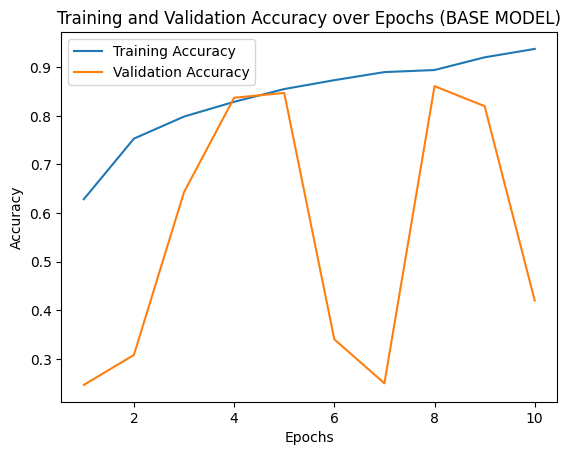

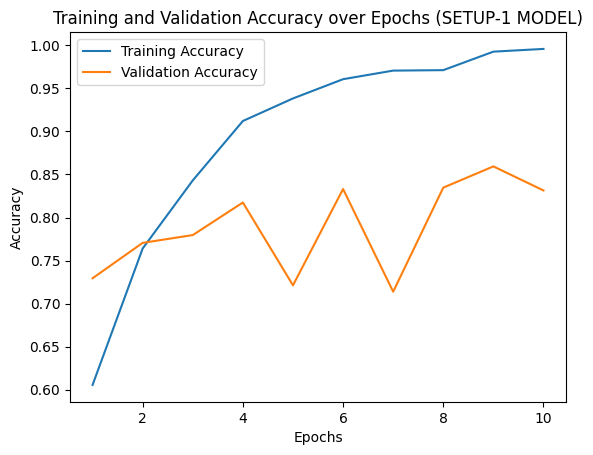

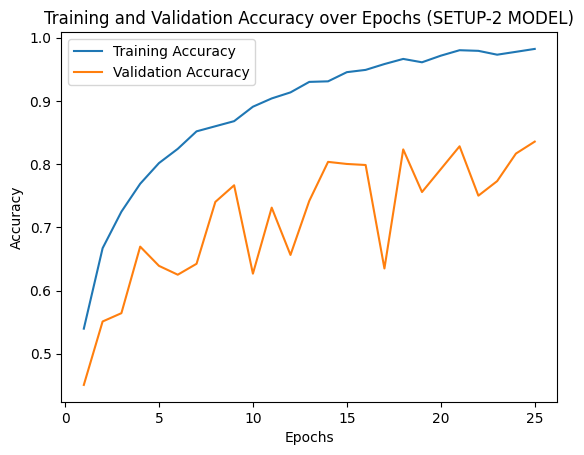

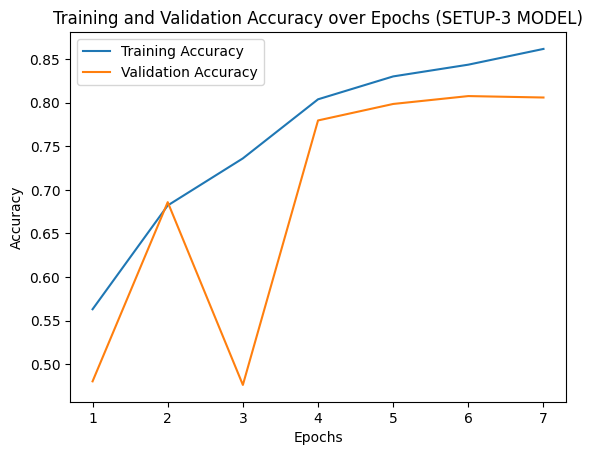

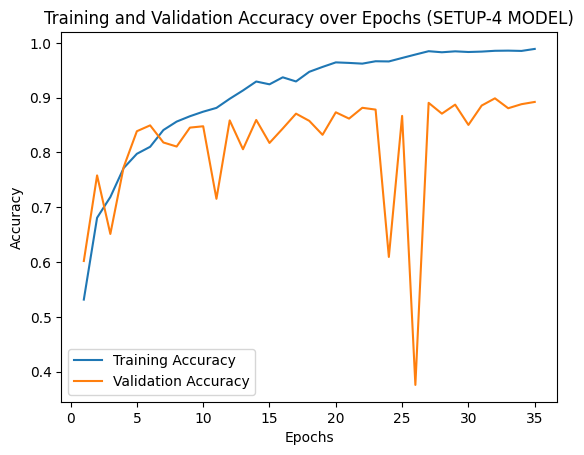

In [ ]:
'''
Plotting the training and validation accuracy over time (epochs).
'''

# BASE MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_base + 1), train_accuracies_base, label='Training Accuracy')
plt.plot(range(1, num_epochs_base + 1), valid_accuracies_base, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (BASE MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-1 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_1 + 1), train_accuracies_1, label='Training Accuracy')
plt.plot(range(1, num_epochs_1 + 1), valid_accuracies_1, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-1 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-2 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_2 + 1), train_accuracies_2, label='Training Accuracy')
plt.plot(range(1, num_epochs_2 + 1), valid_accuracies_2, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-2 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-3 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, last_num_epochs_3 + 1), train_accuracies_3[:last_num_epochs_3], label='Training Accuracy')
plt.plot(range(1, last_num_epochs_3 + 1), valid_accuracies_3[:last_num_epochs_3], label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-3 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-4 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_4 + 1), train_accuracies_4, label='Training Accuracy')
plt.plot(range(1, num_epochs_4 + 1), valid_accuracies_4, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-4 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

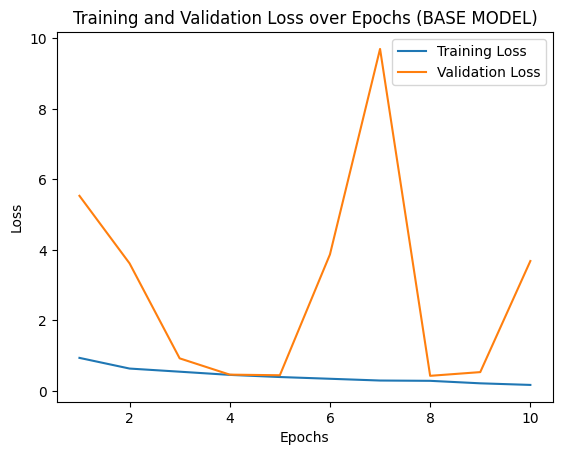

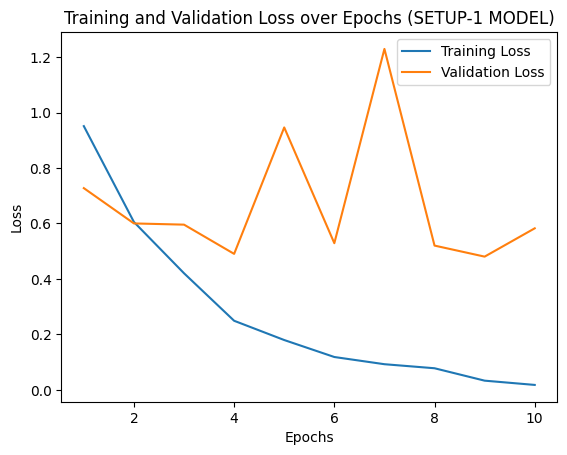

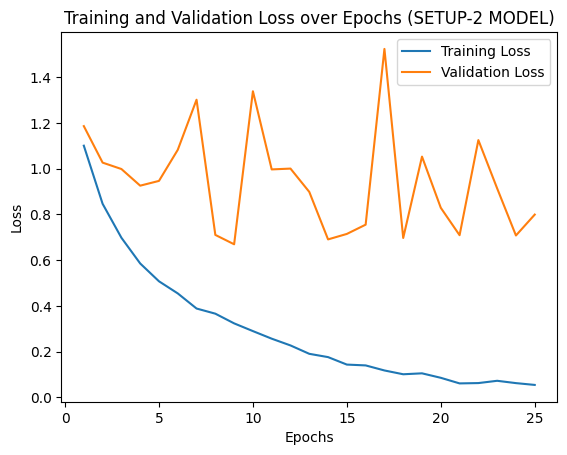

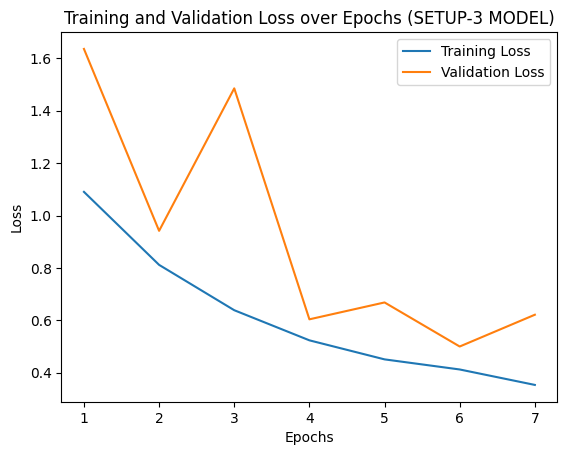

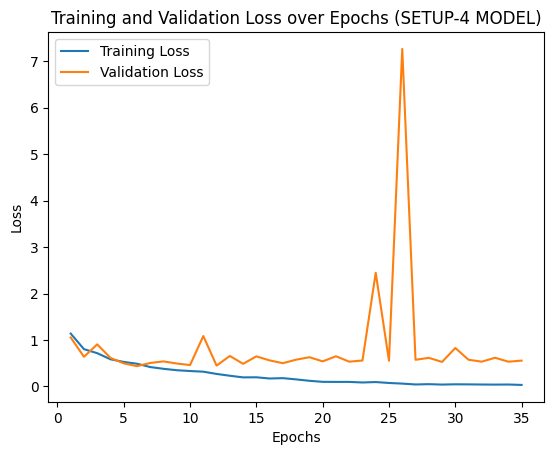

In [ ]:
'''
Plotting the training and validation loss over time (epochs).
'''

# BASE MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_base + 1), train_losses_base, label='Training Loss')
plt.plot(range(1, num_epochs_base + 1), valid_losses_base, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (BASE MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-1 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_1 + 1), train_losses_1, label='Training Loss')
plt.plot(range(1, num_epochs_base + 1), valid_losses_1, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-1 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-2 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_2 + 1), train_losses_2, label='Training Loss')
plt.plot(range(1, num_epochs_2 + 1), valid_losses_2, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-2 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-3 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, last_num_epochs_3 + 1), train_losses_3[:last_num_epochs_3], label='Training Loss')
plt.plot(range(1, last_num_epochs_3 + 1), valid_losses_3[:last_num_epochs_3], label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-3 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-4 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_4 + 1), train_losses_4, label='Training Loss')
plt.plot(range(1, num_epochs_4 + 1), valid_losses_4, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-4 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

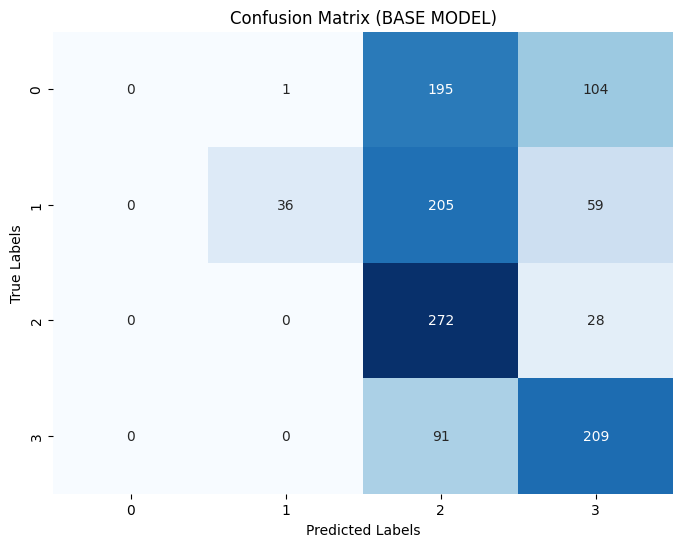

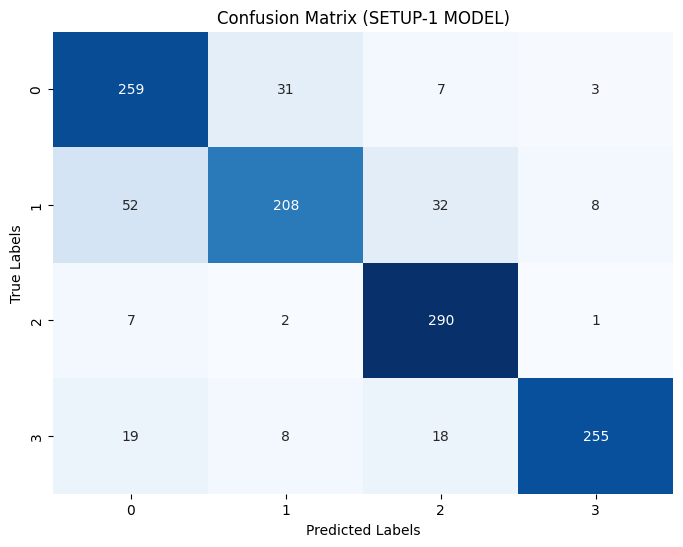

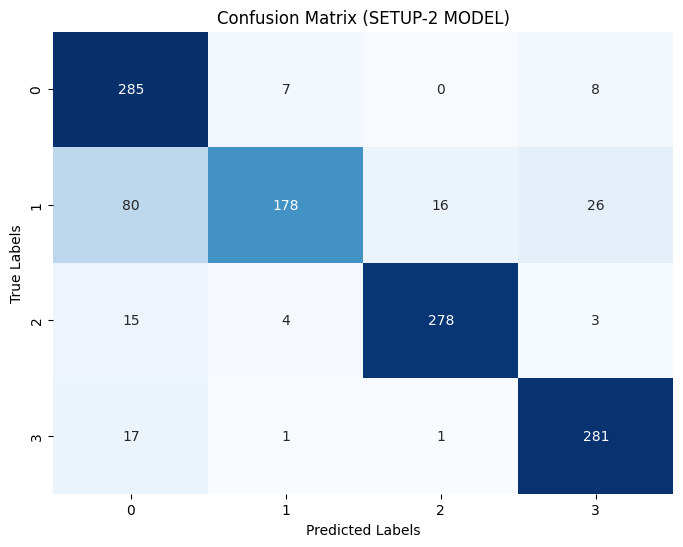

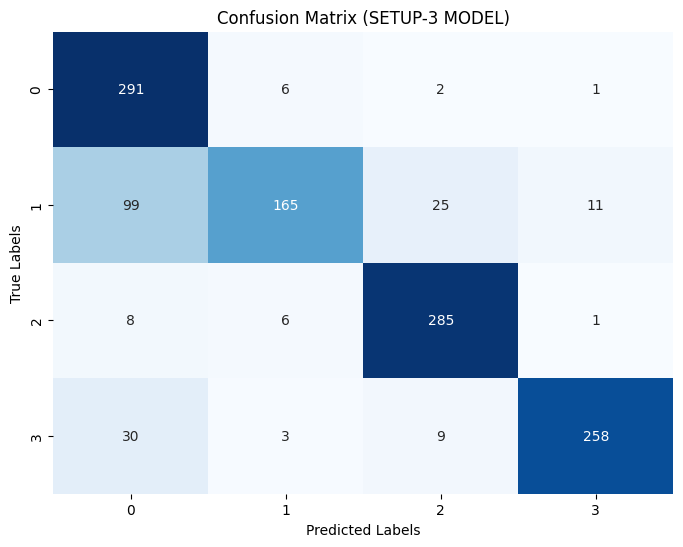

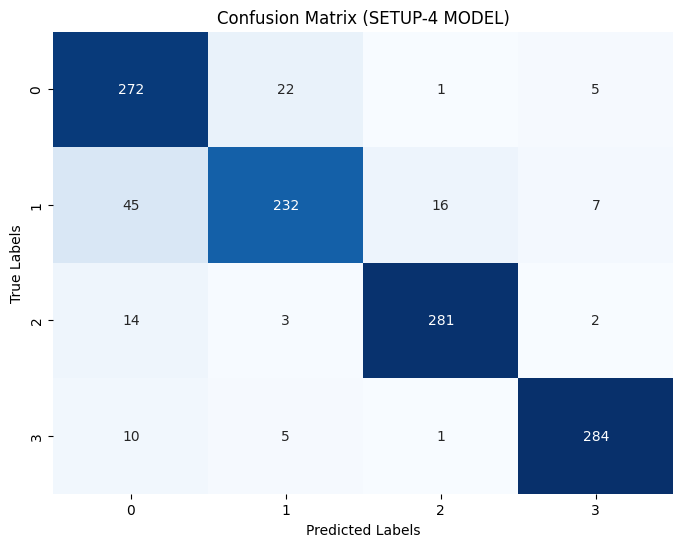

In [ ]:
'''
Generating a confusion matrix using the model's predictions on the test set.
'''

from sklearn.metrics import confusion_matrix

# BASE MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_base = np.array(testing_predictions_base)
true_labels_base = np.array(true_labels_base)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_base, testing_predictions_base)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BASE MODEL)')
plt.show()

print("\n")

# SETUP-1 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_1 = np.array(testing_predictions_1)
true_labels_1 = np.array(true_labels_1)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_1, testing_predictions_1)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-1 MODEL)')
plt.show()

print("\n")

# SETUP-2 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_2 = np.array(testing_predictions_2)
true_labels_2 = np.array(true_labels_2)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_2, testing_predictions_2)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-2 MODEL)')
plt.show()

print("\n")

# SETUP-3 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_3 = np.array(testing_predictions_3)
true_labels_3 = np.array(true_labels_3)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_3, testing_predictions_3)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-3 MODEL)')
plt.show()

print("\n")

# SETUP-4 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_4 = np.array(testing_predictions_4)
true_labels_4 = np.array(true_labels_4)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_4, testing_predictions_4)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-4 MODEL)')
plt.show()

In [ ]:
'''
Calculating and report other evaluation metrics such as Precision, recall and F1
score.
'''

from sklearn.metrics import precision_recall_fscore_support

# BASE MODEL 🔻

print("BASE MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_base, testing_predictions_base, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-1 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_1, testing_predictions_1, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-2 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_2, testing_predictions_2, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-3 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_3, testing_predictions_3, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-4 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_4, testing_predictions_4, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

BASE MODEL 🔻
Precision: 0.4630
Recall: 0.4308
F1-score: 0.3306


SETUP-1 MODEL 🔻
Precision: 0.8487
Recall: 0.8433
F1-score: 0.8417


SETUP-2 MODEL 🔻
Precision: 0.8702
Recall: 0.8517
F1-score: 0.8470


SETUP-3 MODEL 🔻
Precision: 0.8591
Recall: 0.8325
F1-score: 0.8271


SETUP-4 MODEL 🔻
Precision: 0.8940
Recall: 0.8908
F1-score: 0.8906


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
